## **Supervised Dimensionality Reduction and Clustering** - RNA-seq Cancer Gene Expression Data

File:  sapca_cancer_gene_express.ipynb

Author:  Billy Carson

Date written:  05-21-2021

Last modified:  06-06-2021

> Description: This script uses supervised AugmentedPCA (sAPCA) to learn representations and components that have greater class fidelity. The dataset used is a cancer gene expression dataset publically available on the UCI Machine Learning Repository which can be found [here](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq).


### **Import modules**

Once installed via `pip` into the computing environment, AugmentedPCA models can be imported just like any other Python module. Use the command `from apca.models import *` to import all offered AugmentedPCA factor models.


In [17]:
# Import modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import AugmentedPCA models
from apca.models import *

# Define random state
random_state = 0

# Plot switch
# Paper figure: True, documentation example figure: False
paper_fig = False


### **Function definitions**

In [2]:
# Load iris dataset
def load_gene_expression_data(data_path: str):
    r"""
    Load cancer gene expression dataset.
    
    Parameters
    ----------
    data_path : str
        Path where cancer gene expression data is stored.
    
    Returns
    -------
    X : numpy.ndarray
        Cancer gene expression data.
    y : numpy.ndarray
        Tumor type labels.
    class_dic : dict
        Dictionary mapping integer labels to string of tumor type.
    """
    
    # Extract array of iris features
    feat_df = pd.read_csv(data_path + 'data.csv', header=0)
    X = feat_df.iloc[:, 1:].to_numpy()
    
    # Encode labels
    labels_df = pd.read_csv(data_path + 'labels.csv', header=0)
    label_enc = LabelEncoder()
    y = label_enc.fit_transform(labels_df.loc[:, 'Class'].to_list())
    
    # Define class dictionary
    class_list = label_enc.classes_
    class_dict = {}
    for i, class_name in enumerate(class_list):
        class_dict[i] = class_name
    
    # Return feature and labels arrays
    return X, y, class_dict


### **Load cancer gene expression dataset**

The data used in this notebook is RNA-sequencing gene expression data from patients each having a different type of tumor: BRCA, KIRC, COAD, LUAD, or PRAD.

Here, the gene expression data is stored in the matrix `X`, and the categorical labels are stored in the vector `y`. A class dictionary is also created to map the categorical integer values back to their original labels. Labels are then one-hot encoded and stored in a matrix of supervision data `Y` that will be provided to the supervised AugmentedPCA (sAPCA) model later.


In [3]:
# Load iris dataset into feature and labels arrays
data_path = '/hdd/carlson_lab/data/cancer_gene_expression/'
X, y, class_dict = load_gene_expression_data(data_path=data_path)

# One-hot encode labels
onehotenc = OneHotEncoder()
Y = onehotenc.fit_transform(np.reshape(y, newshape=(-1, 1))).toarray()

# Display shape of data
print('\nCancer gene expression dataset dimensions:\n')
print('  Gene expression data:  (%d, %d)' % (X.shape))
print('  Supervision data:  (%d, %d)' % (Y.shape))
print('  Labels:  (%d,)\n' % (y.shape))



Cancer gene expression dataset dimensions:

  Gene expression data:  (801, 20531)
  Supervision data:  (801, 5)
  Labels:  (801,)



### **Split data**

Instead of using all gene expression data, only a subset of the gene expression data will be used. This is because the process of fitting AugmentedPCA models require matrix inversions as well as eigendecompositions. This process gets prohibitively expensive for larger feature dimensions. Thus, it is recommended to keep the feature dimensions to around ~1,000 features, give or take.

Subsequently, we'll call scikit-learn's `train_test_split()` function multiple times to split the data into train and test splits (roughly 50% and 50% of the data, respectively).


In [4]:
# Subset of original data
X_subset = X[:, :2000]

# Split data
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X_subset, Y, y, test_size=0.5,
                                                                     shuffle=True, random_state=random_state)


### **Scale data**

Next, we'll scale our gene expression training features such that each feature has mean zero and unit variance. We'll then scale our  test data according to the population statistics of the training features.

We won't scale our supervision data since it doesn't make sense to scale one-hot encodings.


In [5]:
# Instantiate standard scaler
scaler = StandardScaler()

# Scale gene expression data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### **Define classification model**

For evaluating the classification performance achieved using AugmentedPCA components, we'll use a simple logistic regression classifier with no penalty, since we're only going to use two components for prediction.


In [6]:
# Instantiate logistic regression model
model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000, multi_class='auto',
                           random_state=random_state)


### **PCA components** - 2-dimensional clustering and model classification performance

Here, we will evaluate model performance achieved using two PCA components of the decomposed gene expression data for class prediction. Logistic regression only achieves 65% accuracy on the test set. This is because PCA finds independent sets of features (orthogonal components) that *maximize the explained variance of the data*. If the majority of the variance of the gene expression data is not aligned with class labels then you won't get class separation from the first few principle components. This is reflected in the visualization of the 2-dimensional (2D) clustering. We see nice separation of KIRC from the other cancers, but the other cancers still have a lot of overlap.



Model performance using PCA components (# components = 2):
  Train set:  0.7300
  Test set:  0.7132



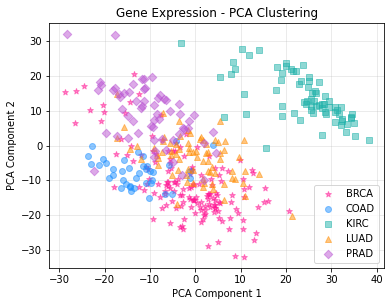

In [19]:
# PCA decomposition
n_components = 2
pca = PCA(n_components=n_components)
S_train = pca.fit_transform(X_train)
S_test = pca.transform(X_test)

# Fit model to training data
model.fit(S_train, y_train)

# Get model predictions
y_pred_train = model.predict(S_train)
y_pred_test = model.predict(S_test)
train_acc = accuracy_score(y_pred_train, y_train)
test_acc = accuracy_score(y_pred_test, y_test)

# Model prediction accuracy
print('\nModel performance using PCA components (# components = %d):' % (n_components))
print('  Train set:  %.4f' % (train_acc))
print('  Test set:  %.4f\n' % (test_acc))

# Plot PCA components of samples in 2D space
color_list = ['deeppink', 'dodgerblue', 'lightseagreen', 'darkorange', 'mediumorchid']
marker_list = ['*', 'o', 's', '^', 'D']
if paper_fig:
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3.9, 3.5))
else:
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 4.5))
for i, label in enumerate(list(np.unique(y_test))):
    ax1.scatter(S_test[np.where(y_test==label), 0], S_test[np.where(y_test==label), 1],
                c=color_list[i], marker=marker_list[i], alpha=0.5, label=class_dict[i])
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.grid(alpha=0.3)
ax1.set_axisbelow(True)
ax1.legend(loc='lower right')

# Save figure
dpi = 600
if paper_fig:
    fig1.savefig('figures/gene_express_pca_cluster_paper.pdf', bbox_inches='tight', dpi=dpi)
else:
    ax1.set_title('Gene Expression - PCA Clustering')
    fig1.savefig('figures/gene_express_pca_cluster_docs.svg', bbox_inches='tight', dpi=dpi)

# Show plot
plt.show()


### **sAPCA components** - Model classification performance

Now, instead of PCA we will use sAPCA to find components that, in addition to maximizing the explained variance of the data, find components that have greater fidelity to class labels. Ideally, this will help separate the different clusters of the gene expression data.

Like scikit-learn's PCA implementation, sAPCA models are fit using the `fit()` and `fit_transform()` methods, with `fit_transform()` returning a matrix of components or factors. The `fit()` and `fit_transform()` methods of AugmentedPCA models require both a primary data matrix `X` and an augmenting data matrix `Y` as parameters. For sAPCA models, the augmenting data is the supervision data matrix `Y`. In this case, this matrix corresponds to our matrix of one-hot encoded class labels.

AugmentedPCA models have a tuning parameter `mu`, which represents the relative strength of the augmenting objective. At lower values of `mu`, AugmentedPCA models will prioritize maximizing explained variance in learned components, and this will produce components similar to that produced by regular PCA. At higher values of `mu`, the augmenting objective is prioritized. Here, since we are using sAPCA, at higher `mu` values the components will (hopefully) have greater clustering according to class.

Since sAPCA has a tuning hyperparameter, we can do a search over the supervision strength space. The magnitude of this value will depend on the dataset, the scale of the features, and the dimensionality of the features. Here, a supervision strength in the thousands is reasonable. For a smaller number of features, these values may be much too large.

Finally, AugmentedPCA models offer multiple "approximate inference strategies." For supervised applications of AugmentedPCA, it's recommended one often chooses the `'encoded'` option, as done below. Essentially, this ensures that the model doesn't need to use the supervision data at test time to create components and instead only relies upon the features.


In [8]:
# Number of sAPCA components
n_components = 2

# List of supervision strength values
mu_lo = 0.0
mu_hi = 5000
mu_step = 100.0
mu_list = list(np.arange(mu_lo, mu_hi + mu_step, mu_step))

# Initialize test accuracy list
train_acc_list = []
test_acc_list = []

# Iterate over supervision strengths
for mu in tqdm(mu_list):
    # PCA decomposition
    apca = sAPCA(n_components=2, mu=mu, inference='encoded')
    S_train = apca.fit_transform(X=X_train, Y=Y_train)
    S_test = apca.transform(X=X_test, Y=None)

    # Fit model to training data
    model.fit(S_train, y_train)

    # Predict on training data
    y_pred_train = model.predict(S_train)
    train_acc = accuracy_score(y_pred_train, y_train)
    train_acc_list.append(train_acc)
    
    # Predict on test data
    y_pred_test = model.predict(S_test)
    test_acc = accuracy_score(y_pred_test, y_test)
    test_acc_list.append(test_acc)

# Model prediction accuracy
print('\nMax model performance using sAPCA components (# components = %d):' % (n_components))
print('  Train set:  %.4f' % (np.max(train_acc_list)))
print('  Test set:  %.4f\n' % (np.max(test_acc_list)))


  0%|          | 0/51 [00:00<?, ?it/s]


Max model performance using sAPCA components (# components = 2):
  Train set:  1.0000
  Test set:  0.9027



### **sAPCA components** - Plot model performance vs supervision strength

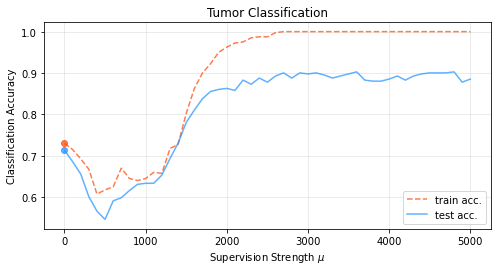

In [20]:
# Plot model performance as a function of adversary strength
if paper_fig:
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(4.8, 3.5))
else:
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8.0, 3.8))
ax2.plot(mu_list, train_acc_list, c='orangered', linestyle='--', alpha=0.7, label='train acc.')
ax2.scatter(mu_list[0], train_acc_list[0], c='orangered', alpha=0.7)
ax2.plot(mu_list, test_acc_list, c='dodgerblue', alpha=0.7, label='test acc.')
ax2.scatter(mu_list[0], test_acc_list[0], c='dodgerblue', alpha=0.7)
ax2.set_xlabel('Supervision Strength $\mu$')
ax2.set_ylabel('Classification Accuracy')
ax2.grid(alpha=0.3)
ax2.set_axisbelow(True)
ax2.legend(loc='lower right')

# Save figure
dpi = 600
if paper_fig:
    fig2.savefig('figures/gene_express_class_pred_paper.pdf', bbox_inches='tight', dpi=dpi)
else:
    ax2.set_title('Tumor Classification')
    fig2.savefig('figures/gene_express_class_pred_docs.svg', bbox_inches='tight', dpi=dpi)

# Show plot
plt.show()


### **sAPCA components** - Sample clustering

Finally, we visualize our sAPCA components in 2D space. We see much greater separation/clustering according to class, which demonstrates that sAPCA successfully learned components that both a) maximized explain variance of the original gene expression data in learned components and b) made sure these components also had greater fidelity with respects to class labels, thus ensuring cleaner clustering according to tumor type.


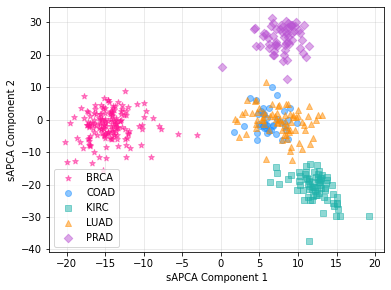

In [16]:
# sAPCA decomposition
apca = sAPCA(n_components=2, mu=2500, inference='encoded')
S_train = apca.fit_transform(X=X_train, Y=Y_train)
S_test = apca.transform(X=X_test, Y=None)

# Plot PCA components of samples in 2D space
color_list = ['deeppink', 'dodgerblue', 'lightseagreen', 'darkorange', 'mediumorchid']
marker_list = ['*', 'o', 's', '^', 'D']
if paper_fig:
    fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(3.9, 3.5))
else:
    fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 4.5))
for i, label in enumerate(list(np.unique(y_test))):
    ax3.scatter(S_test[np.where(y_test==label), 0], S_test[np.where(y_test==label), 1],
                c=color_list[i], marker=marker_list[i], alpha=0.5, label=class_dict[i])
ax3.set_xlabel('sAPCA Component 1')
ax3.set_ylabel('sAPCA Component 2')
ax3.grid(alpha=0.3)
ax3.set_axisbelow(True)
ax3.legend(loc='lower left')

# Save figure
dpi = 600
if paper_fig:
    fig3.savefig('figures/gene_express_sapca_cluster_paper.pdf', bbox_inches='tight', dpi=dpi)
else:
    ax3.set_title('Gene Expression - sAPCA Clustering')
    fig3.savefig('figures/gene_express_sapca_cluster_docs.svg', bbox_inches='tight', dpi=dpi)

# Show plot
plt.show()
